<h1>Hypothesis: "Antartic locations with subterrainian lake will have flatter surafce ice slopes"</h1>

Sources:

https://nsidc.org/data/nsidc-0720/versions/1#anchor-data-access-tools

https://www.npolar.no/quantarctica/#toggle-id-15

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import raster_tools as rt

import cartopy.crs as ccrs

c:\Users\aster\anaconda3\envs\rstools39\lib\site-packages\pyogrio\core.py:23: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()
c:\Users\aster\anaconda3\envs\rstools39\lib\site-packages\fiona\env.py:662: RuntimeWarning: Cannot find header.dxf (GDAL_DATA is not defined)
  elif GDALDataFinder().find_file("header.dxf"):
Cannot find header.dxf (GDAL_DATA is not defined)


In [2]:
# Load lakes
lakes2 = gpd.read_file('data/Quantarctica3/Quantarctica3/Glaciology/Subglacial Lakes/SubglacialLakes_WrightSiegert.shp')
# regex replace spaces in LENGTH_M column
lakes2['LENGTH_M'] = lakes2['LENGTH_M'].str.replace('28100 + 4000', '28100')
lakes2['LENGTH_M'] = lakes2['LENGTH_M'].str.replace('<', '')
lakes2['LENGTH_M'] = lakes2['LENGTH_M'].str.replace(' ', '')
lakes2['LENGTH_M'] = pd.to_numeric(lakes2['LENGTH_M'], errors='coerce')
# make a new col claled SAT_DETECT with a value of 1 if the lake is detected by satellite (CLASS G) and 0 otherwise
lakes2['SAT_DETECT'] = np.where(lakes2['CLASS'] == 'G', 1, 0)

In [3]:
# load ice boundaries
ice_bounds = gpd.read_file('data/Quantarctica3/Quantarctica3/Glaciology/MEaSUREs Antarctic Boundaries/IceBoundaries_Antarctica_v2.shp')

In [4]:
# load flow speed
ice_vel_450 = rt.Raster('data/Quantarctica3/Quantarctica3/Glaciology/MEaSUREs Ice Flow Velocity/MEaSUREs_IceFlowSpeed_450m.tif')

In [5]:
# load DEM
dem = rt.Raster('data/dem/rema_mosaic_500m_v2.0_filled_cop30_dem.tif')

In [6]:
# get slope from dem
slope = rt.surface.slope(dem)

In [7]:
lakes2

,TALLY,NAME,LAT,LON,LENGTH_M,CLASS,WIDTH_M,DEPTH_M,AREA_KM2,VOLUME_KM3,ICETHKNS_M,REFERENCES,geometry,SAT_DETECT
0,1,Sovetskaya Lake,-78.100,88.500,75000.0,F,35000.0,NaN,1600.0,NaN,4200.0,Located beneath Sovetskaya Station. The first ...,POINT (1296999.561 33963.129),0
1,2,Lake Vostok,-78.150,104.500,280000.0,F,44000.0,1067.0,14000.0,5400.0,3945.0,Included in the first inventory of Oswald and ...,POINT (1250803.318 -323479.733),0
2,3,SPRI-3,-76.570,124.800,5000.0,A,NaN,NaN,NaN,NaN,3621.0,Oswald and Robin (1973),POINT (1203517.434 -836466.407),0
3,4,SPRI-4,-73.280,157.280,3500.0,A,NaN,NaN,NaN,NaN,2827.0,Oswald and Robin (1973),POINT (706469.226 -1687214.515),0
4,5,SPRI-5,-77.200,119.270,10000.0,B,NaN,NaN,NaN,NaN,3835.0,Oswald and Robin (1973),POINT (1218054.666 -682702.029),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,375,R13Ea_8,-75.981,106.045,3500.0,A,NaN,NaN,NaN,NaN,3521.0,Wright et al. (2012),POINT (1470914.122 -423028.361),0
375,376,R15Ea_4,-74.084,100.818,1800.0,A,NaN,NaN,NaN,NaN,3523.0,Wright et al. (2012),POINT (1709145.571 -326593.471),0
376,377,Site A,-67.800,112.540,NaN,G,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), drained followed by...",POINT (2255000.417 -935896.682),1
377,378,Site B,-67.870,113.530,NaN,G,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), filling site, near ...",POINT (2231263.202 -971570.334),1


<h4>Plotting</h4>

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from raster_tools import Raster, open_dataset

import cartopy.crs as ccrs

def plot_with_basemap(title, rs=None, vector=None, vect_col=None, rs_cmap='gist_earth', vect_cmap='viridis', vmin=None, vmax=None, rs_mask=False, rs_log_scale=False):

    # Load basemap
    world = gpd.read_file('data/Quantarctica3/Quantarctica3/Miscellaneous/SimpleBasemap/ADD_DerivedLowresBasemap.shp')
    world = world.set_crs(epsg=3031)
    world = world.to_crs(epsg=3031)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})

    world.boundary.plot(ax=ax, transform=ccrs.SouthPolarStereo(), linewidth=0.5, color='blue')

    if rs_mask and rs is not None:
        rs = rt.clipping.mask(world, rs)

    if rs is not None:
        if vmin is None and vmax is None:
            rs.plot(ax=ax, cmap=rs_cmap, transform=ccrs.SouthPolarStereo(), alpha=0.7)
        else:
            rs.plot(ax=ax, cmap=rs_cmap, transform=ccrs.SouthPolarStereo(), alpha=0.7, vmin=vmin, vmax=vmax)

    if vector is not None:
        vector.plot(ax=ax, column=vect_col, cmap=vect_cmap, transform=ccrs.SouthPolarStereo(), legend=True, markersize=5)

    # Adjust map extent
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # Adjust bounds for rotation

    ax.set_title(title)
    plt.show()

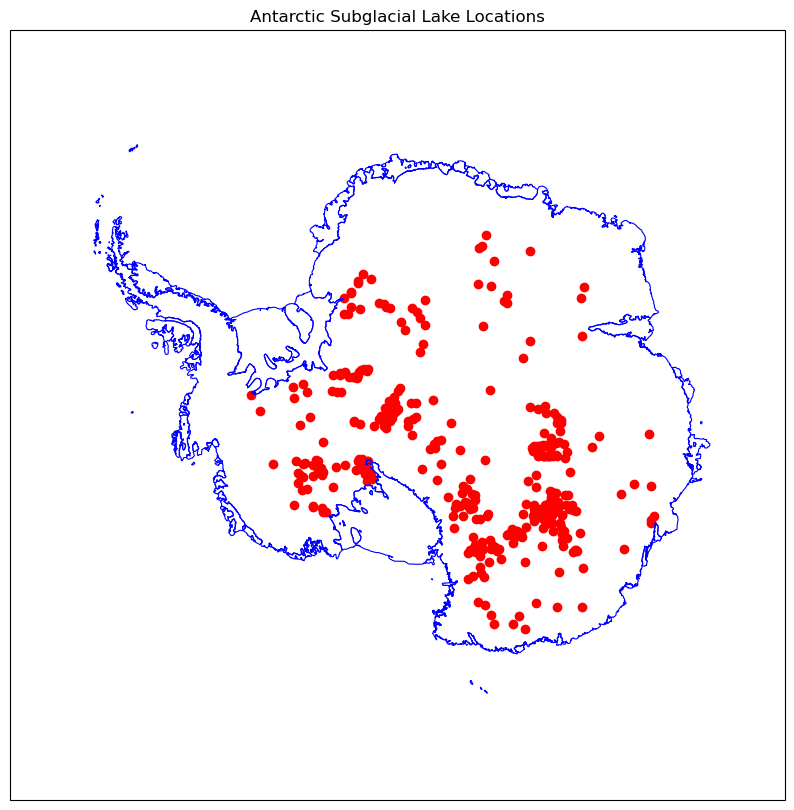

In [9]:
world = gpd.read_file('data\coastline\ADD_Coastline_low_res_polygon.shp')
world = world.to_crs(epsg=3031)
world = world.to_crs(epsg=3031)

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})
world.boundary.plot(ax=ax, transform=ccrs.SouthPolarStereo(), linewidth=0.8, color='blue')
lakes2.plot(ax=ax, color='red',
               legend_kwds={'label': "Ice Thickness (m)"}, transform=ccrs.SouthPolarStereo())

# Adjust map extent if needed
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # Adjust bounds for rotation

plt.title("Antarctic Subglacial Lake Locations")
plt.show()

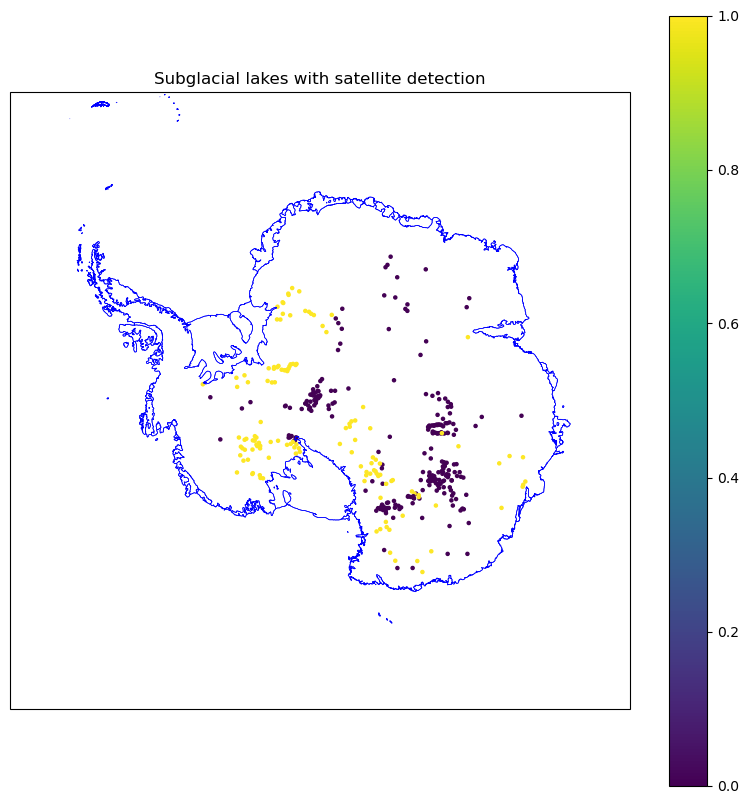

In [57]:
plot_with_basemap('Subglacial lakes with satellite detection',vector=lakes2, vect_col='SAT_DETECT', vect_cmap='viridis')

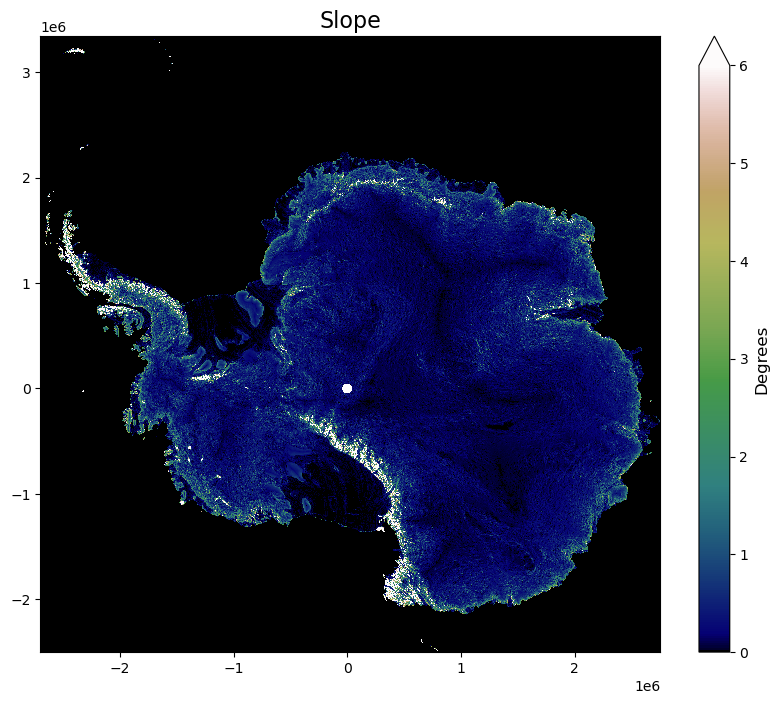

In [8]:
import matplotlib.pyplot as plt

# Create a plot for the log-scaled slope
fig, ax = plt.subplots(figsize=(10, 8))
cax = slope.plot(cmap='gist_earth', ax=ax, vmax=6)

# Add a title to the plot
ax.set_title("Slope", fontsize=16)

# Add colorbar with label (this is the colorbar from the plot)
cbar = plt.gca().collections[0].colorbar
cbar.set_label('Degrees', fontsize=12)

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

c:\Users\aster\anaconda3\envs\rstools39\lib\site-packages\dask\core.py:127: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))


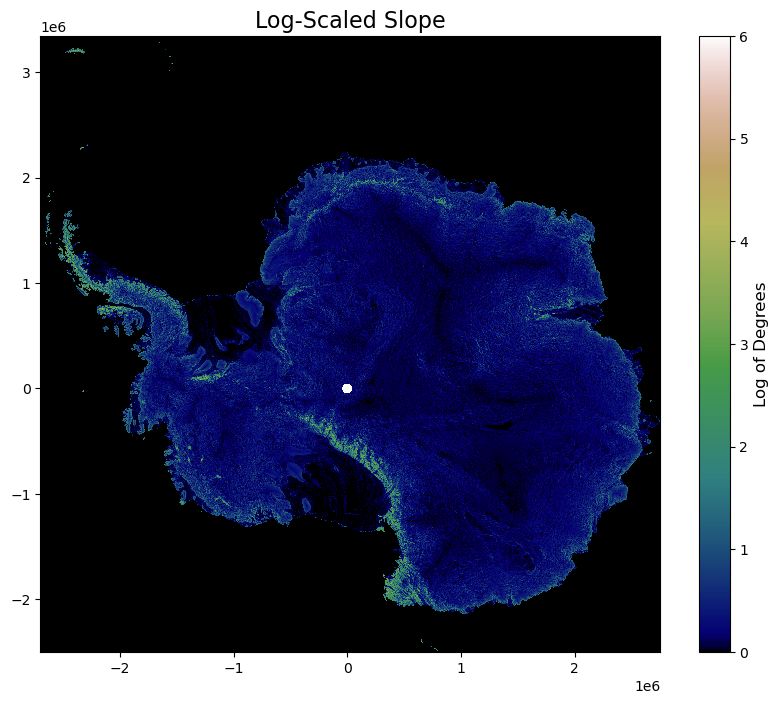

In [7]:
import matplotlib.pyplot as plt

# Log scale the slope
slope_log = np.log(slope + 1)

# Create a plot for the log-scaled slope
fig, ax = plt.subplots(figsize=(10, 8))
cax = slope_log.plot(cmap='gist_earth', ax=ax, vmax=6)

# Add a title to the plot
ax.set_title("Log-Scaled Slope", fontsize=16)

# Add colorbar with label (this is the colorbar from the plot)
cbar = plt.gca().collections[0].colorbar
cbar.set_label('Log of Degrees', fontsize=12)

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

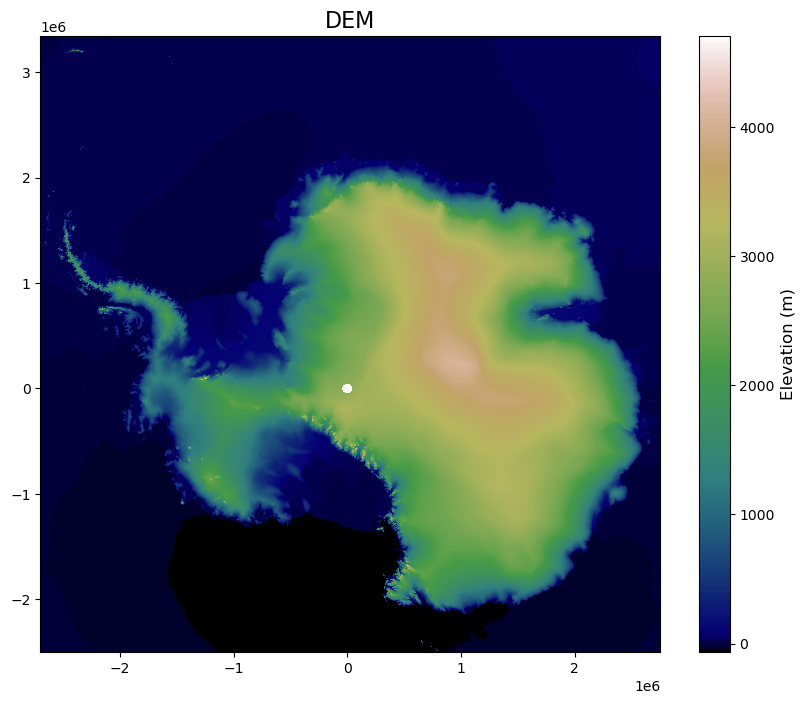

In [10]:
import matplotlib.pyplot as plt

# Create a plot for the log-scaled slope
fig, ax = plt.subplots(figsize=(10, 8))
cax = dem.plot(cmap='gist_earth', ax=ax, vmin=dem.min().compute(), vmax=dem.max().compute())

# Add a title to the plot
ax.set_title("DEM", fontsize=16)

# Add colorbar with label (this is the colorbar from the plot)
cbar = plt.gca().collections[0].colorbar
cbar.set_label('Elevation (m)', fontsize=12)

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

<h3>Do "flatter slopes" congregate above subglacial lakes?</h3>

Assign Slope value to each gdf point

In [8]:
lake_coords = np.array([lakes2.geometry.x, lakes2.geometry.y]).T

lake_coords

array([[ 1.29699956e+06,  3.39631288e+04],
       [ 1.25080332e+06, -3.23479733e+05],
       [ 1.20351743e+06, -8.36466407e+05],
       [ 7.06469226e+05, -1.68721451e+06],
       [ 1.21805467e+06, -6.82702029e+05],
       [ 1.42630214e+06, -9.99449671e+05],
       [-9.23610778e+04, -1.59974079e+05],
       [ 1.60686305e+06, -1.08139627e+06],
       [ 1.10819174e+06, -9.20038510e+05],
       [ 1.21930809e+06, -9.32568681e+05],
       [ 1.24452105e+06, -9.22915550e+05],
       [ 1.27415713e+06, -9.12206913e+05],
       [ 1.30162654e+06, -8.34346730e+05],
       [ 1.29678286e+06, -9.76486461e+05],
       [ 1.57498266e+06, -8.92534397e+05],
       [ 1.05600034e+06, -1.06857087e+06],
       [ 5.76847605e+05, -9.32902935e+05],
       [ 1.28310945e+06, -1.03533881e+06],
       [ 1.25550141e+06, -8.77479738e+05],
       [ 1.25663594e+06, -9.11994544e+05],
       [ 1.25644935e+06, -9.29045063e+05],
       [ 1.34966080e+06, -9.34584298e+05],
       [ 1.35553340e+06, -7.94968736e+05],
       [ 1.

In [9]:
# Extract raster data and affine transform
slope_array = slope.to_numpy()  # Convert raster to a NumPy array
affine_transform = slope.affine  # Affine transform for mapping coordinates
nodata_value = slope.null_value  # No-data value

In [10]:
# Function to map geographic coordinates to array indices
def coords_to_indices(x, y, transform):
    col, row = ~transform * (x, y)
    return int(row), int(col)

# Extract slope values for each lake point
lake_slopes = []
for geom in lakes2.geometry:
    row, col = coords_to_indices(geom.x, geom.y, affine_transform)
    if 0 <= row < slope_array.shape[1] and 0 <= col < slope_array.shape[2]:  # Check bounds
        value = slope_array[0, row, col]  # Access the value from the raster
        lake_slopes.append(value if value != nodata_value else None)
    else:
        lake_slopes.append(None)  # Out-of-bounds points

# Add extracted values to GeoDataFrame
lakes2["slope"] = lake_slopes

lakes2

,TALLY,NAME,LAT,LON,LENGTH_M,CLASS,WIDTH_M,DEPTH_M,AREA_KM2,VOLUME_KM3,ICETHKNS_M,REFERENCES,geometry,SAT_DETECT,slope
0,1,Sovetskaya Lake,-78.100,88.500,75000.0,F,35000.0,NaN,1600.0,NaN,4200.0,Located beneath Sovetskaya Station. The first ...,POINT (1296999.561 33963.129),0,0.086016
1,2,Lake Vostok,-78.150,104.500,280000.0,F,44000.0,1067.0,14000.0,5400.0,3945.0,Included in the first inventory of Oswald and ...,POINT (1250803.318 -323479.733),0,0.114682
2,3,SPRI-3,-76.570,124.800,5000.0,A,NaN,NaN,NaN,NaN,3621.0,Oswald and Robin (1973),POINT (1203517.434 -836466.407),0,0.029392
3,4,SPRI-4,-73.280,157.280,3500.0,A,NaN,NaN,NaN,NaN,2827.0,Oswald and Robin (1973),POINT (706469.226 -1687214.515),0,0.227904
4,5,SPRI-5,-77.200,119.270,10000.0,B,NaN,NaN,NaN,NaN,3835.0,Oswald and Robin (1973),POINT (1218054.666 -682702.029),0,0.057291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,375,R13Ea_8,-75.981,106.045,3500.0,A,NaN,NaN,NaN,NaN,3521.0,Wright et al. (2012),POINT (1470914.122 -423028.361),0,0.095858
375,376,R15Ea_4,-74.084,100.818,1800.0,A,NaN,NaN,NaN,NaN,3523.0,Wright et al. (2012),POINT (1709145.571 -326593.471),0,0.056701
376,377,Site A,-67.800,112.540,NaN,G,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), drained followed by...",POINT (2255000.417 -935896.682),1,0.229883
377,378,Site B,-67.870,113.530,NaN,G,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), filling site, near ...",POINT (2231263.202 -971570.334),1,0.525441


Next lets understand what slopes indicate

In [11]:
# create a 1km buffer around the lakes
# lakes2['geometry_buffer'] = lakes2.buffer(1000)

# get zonal states for the slope for all lakes
slope_zonal = rt.zonal.zonal_stats(lakes2, slope, stats=['mean', 'median', 'max', 'min'])

In [12]:
slope_zonal = slope_zonal.compute()
slope_zonal = slope_zonal['band_1']

c:\Users\aster\anaconda3\envs\rstools39\lib\site-packages\rasterio\features.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)


In [13]:
slope_zonal

,mean,median,max,min
zone,,,,
348,0.180767,0.180767,0.180767,0.180767
70,0.069198,0.069198,0.069198,0.069198
60,0.011084,0.011084,0.011084,0.011084
316,0.573157,0.573157,0.573157,0.573157
240,0.284154,0.284154,0.284154,0.284154
...,...,...,...,...
151,0.040296,0.040296,0.040296,0.040296
379,0.516714,0.516714,0.516714,0.516714
363,0.138681,0.138681,0.138681,0.138681


In [14]:
slope_zonal['min'].sort_values(ascending=False)

zone
258    2.159162
278    1.563556
296    1.275975
317    1.064880
274    1.041516
         ...   
212         NaN
193         NaN
191         NaN
63          NaN
200         NaN
Name: min, Length: 379, dtype: float64

<Axes: xlabel='SAT_DETECT'>

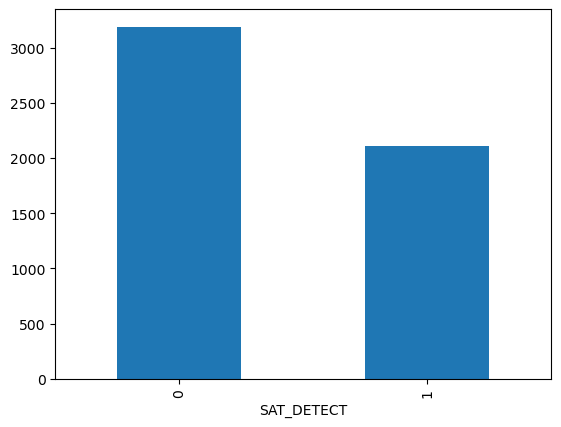

In [15]:
# plot average ICETHKNS_M vs CLASS
lakes2.groupby('SAT_DETECT')['ICETHKNS_M'].mean().plot(kind='bar')

In [16]:
# zonal stats for the lakes
zonal_stats = rt.zonal.zonal_stats(lakes2, dem, stats=['mean', 'max', 'min', 'std', 'median'])

In [17]:
zonal_stats.compute()

band_1                                           
             mean          max          min std       median
zone                                                        
348    291.671875   291.671875   291.671875 NaN   291.671875
70    1911.796875  1911.796875  1911.796875 NaN  1911.796875
60    1798.179688  1798.179688  1798.179688 NaN  1798.179688
316    380.187500   380.187500   380.187500 NaN   380.187500
240   1229.578125  1229.578125  1229.578125 NaN  1229.578125
...           ...          ...          ...  ..          ...
151   2752.164062  2752.164062  2752.164062 NaN  2752.164062
379    871.570312   871.570312   871.570312 NaN   871.570312
363   2217.820312  2217.820312  2217.820312 NaN  2217.820312
378    933.710938   933.710938   933.710938 NaN   933.710938
377   1052.968750  1052.968750  1052.968750 NaN  1052.968750

[379 rows x 5 columns]

In [18]:
slope_zonal['min'].mean()

0.16817166521899624

define "flatter" and see correlation between slope and lakes

In [19]:
slope_np = slope.to_numpy()
slope_np = slope_np.flatten()
slope_np = slope_np[~np.isnan(slope_np)]  # Remove NaN values
slope_np = slope_np[slope_np != -999999.0] # Remove fill values

In [20]:
# Summary statistics for raster
raster_mean = np.mean(slope_np)
raster_std = np.std(slope_np)
raster_min = np.min(slope_np)
raster_max = np.max(slope_np)

print(f"Raster Mean: {raster_mean}, Std Dev: {raster_std}, Min: {raster_min}, Max: {raster_max}")

Raster Mean: 0.24870854059471897, Std Dev: 1.2076309401356453, Min: 0.0, Max: 61.6018216800063


In [21]:
# Summary statistics for lakes2 slopes
point_mean = lakes2['slope'].mean()
point_std = lakes2['slope'].std()
point_min = lakes2['slope'].min()
point_max = lakes2['slope'].max()

print(f"Point Mean: {point_mean}, Std Dev: {point_std}, Min: {point_min}, Max: {point_max}")

Point Mean: 0.1681716652189962, Std Dev: 0.22513976947910488, Min: 0.0008522493294200378, Max: 2.159161736003703


Histograms -- Viewing Slopes

In [28]:
import seaborn as sns

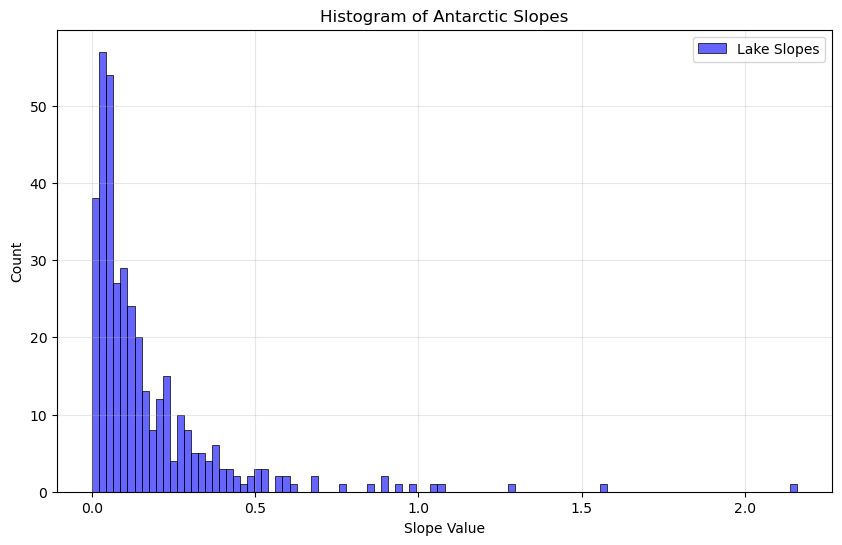

In [42]:
# #Plot histogram of Lake Slopes
# sns.histplot(lakes2['slope'], bins=30, color='blue', alpha=0.6, label='Lake Slopes')

plt.figure(figsize=(10, 6))

sns.histplot(
    lakes2['slope'], kde=False, bins=100, color='blue', alpha=0.6, 
    label='Lake Slopes', stat='count'
)


plt.xlabel('Slope Value')
plt.ylabel('Count')
plt.title('Histogram of Antarctic Slopes')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [30]:
print(f"Size of slope_np: {len(slope_np)}")
print(f"Number of lakes: {len(lakes2)}")

#we dont need 127284292 samples
sampled_slope_np = np.random.choice(slope_np, size=100000, replace=False)

Size of slope_np: 127284292
Number of lakes: 379


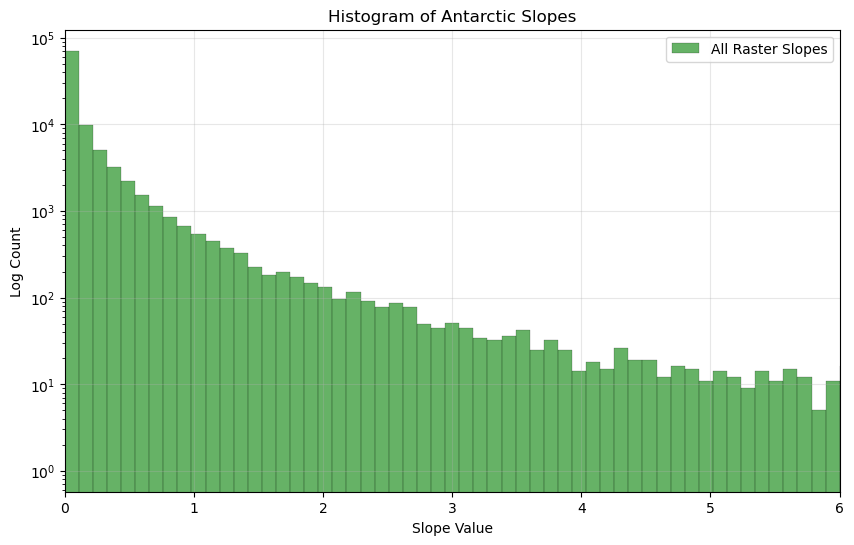

In [71]:
plt.figure(figsize=(10, 6))

sns.histplot(
    sampled_slope_np, kde=False, bins=400, color='green', alpha=0.6, 
    label='All Raster Slopes', stat='count'
)

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlim(0,6)

plt.xlabel('Slope Value')
plt.ylabel('Log Count')
plt.title('Histogram of Antarctic Slopes')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Comparing Slopes

In [65]:
import numpy as np
import scipy.stats as stats

print("All Slopes Mean", raster_mean, "\nLake Slopes Mean", point_mean, "\n")

# grab lake slopes
lake_slopes = lakes2['slope'].values

# clean data
lake_slopes_cleaned = lake_slopes[~np.isnan(lake_slopes)]
sampled_slope_np_cleaned = sampled_slope_np[~np.isnan(sampled_slope_np)]

# t, p tests
t_stat, p_value = stats.ttest_ind(lake_slopes_cleaned, sampled_slope_np_cleaned, equal_var=False)

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


All Slopes Mean 0.24870854059471897 
Lake Slopes Mean 0.1681716652189962 

T-statistic: -6.271860032327618
P-value: 8.252621742601189e-10


Lake slopes do happen to have lower mean slope than overall

In [70]:
import numpy as np

# Calculate a threshold for "flat" slopes
flat_threshold = np.percentile(slope_np, 25)  # Bottom 25% of slopes from raster
print(f"Flat slope threshold: {flat_threshold}")

flat_raster = slope_np[slope_np <= flat_threshold]
flat_percentage_raster = len(flat_raster) / len(slope_np) * 100
print(f"{flat_percentage_raster:.2f}% of the raster is in flatter areas.")

flat_lakes = lakes2[lakes2['slope'] <= flat_threshold]
flat_percentage = len(flat_lakes) / len(lakes2) * 100
print(f"{flat_percentage:.2f}% of lakes are located in flatter areas.")

Flat slope threshold: 0.0010009160765785867
27.36% of the raster is in flatter areas.
0.26% of lakes are located in flatter areas.


In [72]:
import numpy as np

# Calculate the percentile thresholds for flat, normal, and steep slopes
flat_threshold = np.percentile(slope_np, 25)  # Bottom 25% for flat
steep_threshold = np.percentile(slope_np, 75)  # Top 25% for steep

print(f"Flat slope threshold: {flat_threshold}")
print(f"Steep slope threshold: {steep_threshold}")

# Classify lakes based on their slope values
lakes2['slope_category'] = np.where(lakes2['slope'] <= flat_threshold, 'Flat', 
                                   np.where(lakes2['slope'] >= steep_threshold, 'Steep', 'Normal'))

# Count the number of lakes in each category
flat_lakes = lakes2[lakes2['slope_category'] == 'Flat']
normal_lakes = lakes2[lakes2['slope_category'] == 'Normal']
steep_lakes = lakes2[lakes2['slope_category'] == 'Steep']

# Print the results
print(f"Number of lakes in flat areas: {len(flat_lakes)}")
print(f"Number of lakes in normal areas: {len(normal_lakes)}")
print(f"Number of lakes in steep areas: {len(steep_lakes)}")


Flat slope threshold: 0.0010009160765785867
Steep slope threshold: 0.14706325469537704
Number of lakes in flat areas: 1
Number of lakes in normal areas: 247
Number of lakes in steep areas: 131


Previous idea that "lake slopes have lower mean slope" is true, but doesn't explain full story

In [73]:
import scipy.stats as stats
import numpy as np

# Count of lakes in each slope category
flat_lakes_count = len(flat_lakes)
normal_lakes_count = len(normal_lakes)
steep_lakes_count = len(steep_lakes)

# Total number of lakes
total_lakes_count = len(lakes2)

# Percentage of lakes in each category
flat_lakes_percentage = flat_lakes_count / total_lakes_count * 100
normal_lakes_percentage = normal_lakes_count / total_lakes_count * 100
steep_lakes_percentage = steep_lakes_count / total_lakes_count * 100

print(f"Flat lakes: {flat_lakes_percentage:.2f}%")
print(f"Normal lakes: {normal_lakes_percentage:.2f}%")
print(f"Steep lakes: {steep_lakes_percentage:.2f}%")

# Distribution of slopes (flat, normal, steep) in the raster
flat_raster_percentage = np.sum(slope_np <= flat_threshold) / len(slope_np) * 100
normal_raster_percentage = np.sum((slope_np > flat_threshold) & (slope_np < steep_threshold)) / len(slope_np) * 100
steep_raster_percentage = np.sum(slope_np >= steep_threshold) / len(slope_np) * 100

print(f"Raster flat area: {flat_raster_percentage:.2f}%")
print(f"Raster normal area: {normal_raster_percentage:.2f}%")
print(f"Raster steep area: {steep_raster_percentage:.2f}%")

# Observed frequencies (lakes in each category)
observed = np.array([flat_lakes_count, normal_lakes_count, steep_lakes_count])

# Expected frequencies (based on raster distribution)
expected = np.array([flat_raster_percentage * total_lakes_count / 100,
                     normal_raster_percentage * total_lakes_count / 100,
                     steep_raster_percentage * total_lakes_count / 100])

# Perform a Chi-squared test to compare the observed and expected frequencies
chi2_stat, p_value = stats.chisquare(observed, expected)

print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value}")

# If the p-value is low (typically < 0.05), it suggests the hypothesis is likely wrong


Flat lakes: 0.26%
Normal lakes: 65.17%
Steep lakes: 34.56%
Raster flat area: 27.36%
Raster normal area: 47.64%
Raster steep area: 25.00%
Chi-squared statistic: 140.0023143136968
P-value: 3.9708521775823365e-31


space



In [ ]:
lake_slopes_valid = lakes2['slope'].dropna()  # Remove NaN values
slope_np_valid = slope_np[~np.isnan(slope_np)]  # Ensure no NaN in raster slopes
slope_np_valid = slope_np_valid[slope_np_valid != -999999.0]  # Remove fill values

slope_np_valid

array([0.00089525, 0.00100092, 0.00100092, ..., 0.00096265, 0.00080696,
       0.00080696], dtype=float64)

In [ ]:
print(f"Variance of lake slopes: {lake_slopes_valid.var()}")
print(f"Variance of raster slopes: {slope_np_valid.var()}")

Variance of lake slopes: 0.05068791580110448
Variance of raster slopes: 1.4583724875729027


In [ ]:
print(f"Number of lake slopes: {len(lake_slopes_valid)}")
print(f"Number of raster slopes: {len(slope_np_valid)}")

Number of lake slopes: 374
Number of raster slopes: 127284292


negative t value suggests that lakes tend to be located in areas with flatter slopes

small p value indicates statistically signifigant result, not chance

i.e. Lakes are located in areas with flatter slopes, but most flat slopes don't seem to have lakes. This is becuase of a lack lake discovery.

<h4>Proximity Raster</h4>

In [32]:
lakes_vector = rt.Vector(lakes2)

In [33]:
# rasterize the lakes
lakes_raster = rt.rasterize.rasterize(lakes_vector, dem, field='TALLY')

In [34]:
prox_raster = rt.distance.pa_proximity(lakes_raster, target_values=np.arange(1, 380).astype(int))

# Load basemap
world = gpd.read_file('data/Quantarctica3/Quantarctica3/Miscellaneous/SimpleBasemap/ADD_DerivedLowresBasemap.shp')
world.set_crs(epsg=3031, inplace=True)
world = world.to_crs(epsg=3031)

# clip prox raster to world
# prox_raster = prox_raster.clip(world.geometry)
prox_clipped = rt.clipping.clip(world, prox_raster)

Text(0.5, 1.0, 'Proximity to Subglacial Lakes')

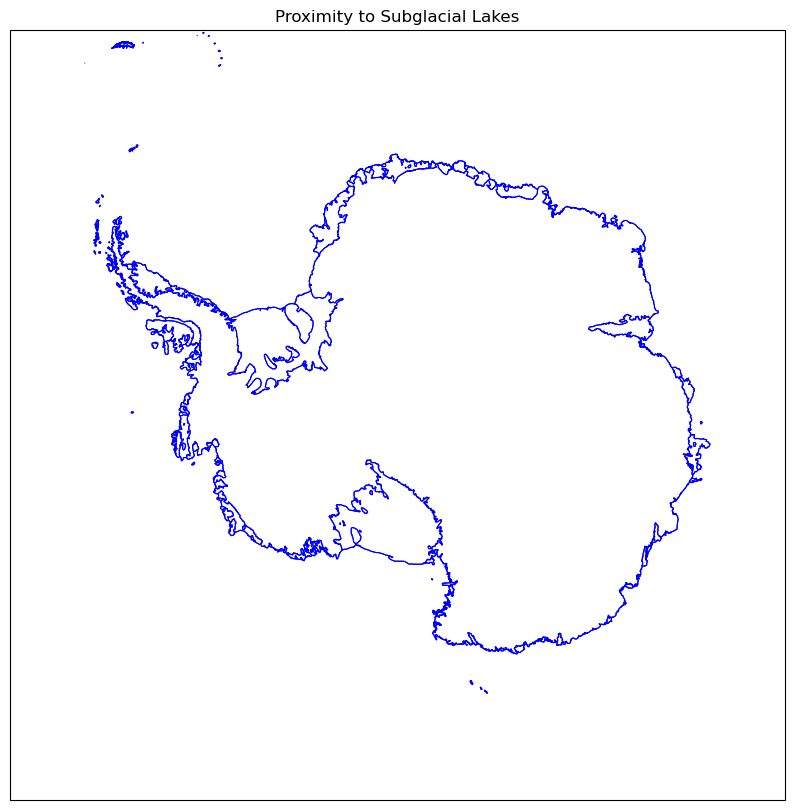

In [35]:
# Load Antarctic shapefile and transform to EPSG:3031
world = gpd.read_file('data/Quantarctica3/Quantarctica3/Miscellaneous/SimpleBasemap/ADD_DerivedLowresBasemap.shp')
world.set_crs(epsg=3031, inplace=True)
world = world.to_crs(epsg=3031)

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})
world.boundary.plot(ax=ax, transform=ccrs.SouthPolarStereo(), linewidth=0.8, color='blue')

# prox_clipped.plot(ax=ax, cmap='gist_earth', transform=ccrs.SouthPolarStereo(), alpha=0.8)

# Adjust map extent
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # Adjust bounds for rotation

plt.title("Proximity to Subglacial Lakes")
# plt.show()

In [36]:
# plot_with_basemap('Proximity to Subglacial Lakes, 500m', rs=prox_raster, rs_cmap='viridis', rs_mask=True)

<h4>Additional Lake Clustering</h4>

  File "c:\Users\aster\anaconda3\envs\rstools39\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\aster\anaconda3\envs\rstools39\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\aster\anaconda3\envs\rstools39\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\aster\anaconda3\envs\rstools39\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


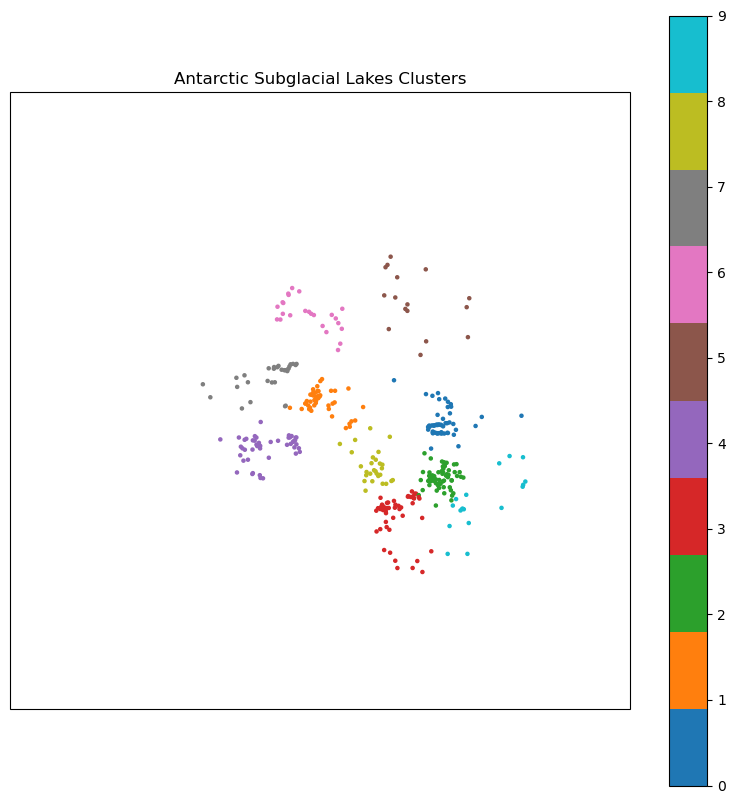

In [37]:
# we will cluster the lakes from lakes2 gdf using kmeans.  the goal is to create a new column in the gdf called 'CLUSTER' that will have the cluster number for each lake, then plot the clusters on the map
from sklearn.cluster import KMeans

# get the coordinates of the lakes
lakes2['X'] = lakes2.geometry.x
lakes2['Y'] = lakes2.geometry.y

# create a new df with only the coordinates
X = lakes2[['X', 'Y']]
# fit the kmeans model
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
# get the cluster labels
lakes2['CLUSTER'] = kmeans.labels_

# Plot
plot_with_basemap('Antarctic Subglacial Lakes Clusters',vector=lakes2, vect_col='CLUSTER', vect_cmap='tab10')